# Child Action Recognition based on our dataset. Part 2 - training the model on adults
**Authors: Andrey Yershov, Aigerim Keutayeva, Serzhan Safin**

This work is based on the following paper: [Large-Scale Weakly-Supervised Pre-Training for Video Action Recognition](https://openaccess.thecvf.com/content_CVPR_2019/html/Ghadiyaram_Large-Scale_Weakly-Supervised_Pre-Training_for_Video_Action_Recognition_CVPR_2019_paper.html)

In this notebook, we finetune the pretrained R(2+1)D model from Microsoft Computer Vision library on dataset that was published on ICPR'04. The dataset could be obtained [here](https://www.csc.kth.se/cvap/actions/). The dataset paper: [Recognizing human actions: a local SVM approach](https://ieeexplore.ieee.org/document/1334462)


##Installation, import and initialization of all required packages

In [1]:
 pip install nteract-scrapbook

     |████████████████████████████████| 266kB 6.9MB/s 
     |████████████████████████████████| 1.1MB 9.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 112kB 14.7MB/s 
     |████████████████████████████████| 727kB 12.6MB/s 
     |████████████████████████████████| 747kB 23.9MB/s 
  Created wheel for black: filename=black-20.8b1-cp36-none-any.whl size=124186 sha256=7ad54490d3a3e4bbd6c8e7e1f5fad8260a53f26b52e9eb1a87e7812e2d719fd8
  Stored in directory: /root/.cache/pip/wheels/6e/10/b5/edf7359c2edd0305cce7e3f96e07daf7ce55dceac9d3ce3373
Successfully built black
  Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5


In [2]:
 pip install git+https://github.com/microsoft/computervision-recipes.git

  Cloning https://github.com/microsoft/computervision-recipes.git to /tmp/pip-req-build-1xloihex
  Running command git clone -q https://github.com/microsoft/computervision-recipes.git /tmp/pip-req-build-1xloihex
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 215kB 5.4MB/s 
     |████████████████████████████████| 983kB 9.0MB/s 
     |████████████████████████████████| 81kB 7.6MB/s 
     |████████████████████████████████| 2.1MB 16.2MB/s 
     |████████████████████████████████| 112kB 35.7MB/s 
     |████████████████████████████████| 14.1MB 253kB/s 
     |████████████████████████████████| 8.6MB 22.7MB/s 
     |████████████████████████████████| 153kB 41.0MB/s 
     |████████████████████████████████| 102kB 11.0MB/s 
     |████████████████████████████████| 112kB 49.5MB/s 
     |████████████████████████████████| 92kB 

In [3]:
 pip install decord --upgrade

     |████████████████████████████████| 11.8MB 270kB/s 


In [4]:
 pip install einops

In [5]:
import sys

sys.path.append("../../")

import numpy as np
import os
from pathlib import Path
import time
import warnings

from sklearn.metrics import accuracy_score
import scrapbook as sb
import torch
import torchvision

from utils_cv.action_recognition.data import Urls
from utils_cv.action_recognition.dataset import VideoDataset
from utils_cv.action_recognition.model import VideoLearner 
from utils_cv.common.gpu import system_info
from utils_cv.common.data import data_path, unzip_url

system_info()
warnings.filterwarnings('ignore')

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0] 

PyTorch 1.7.0+cu101 

Torch-vision 0.8.1+cu101 

Available devices:
0: Tesla P100-PCIE-16GB


In [6]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Importing and preparing our dataset

We import the dataset from our Google Drive.

In [7]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [8]:
# Path to FULL dataset (1 zip was damaged, causes COLAB crash)
# DATA_PATH = '/content/gdrive/MyDrive/Final-project/dataset-cut'

# Path to cut dataset (working, max accuracy 75%)
# DATA_PATH = '/content/gdrive/MyDrive/Final-project/dataset-cut'

# Path to dataset excluding 'run' action (max accuracy 88%)
# DATA_PATH = '/content/gdrive/MyDrive/Final-project/dataset-cut-exclude-run'

# Path to hmdb51 dataset (walk and run videos amount wes decreased to match our dataset)
# DATA_PATH = '/content/gdrive/MyDrive/Final-project/dataset-hmdb51-cut'

# Path to icpr dataset (almost identical to our dataset, bit with grown-ups)
DATA_PATH = '/content/gdrive/MyDrive/Final-project/dataset-icpr'

# Number of consecutive frames used as input to the DNN. 32 for high accuracy, 8 for inference speed. 
# 32 only works with COLAB notebook with 25GB RAM
MODEL_INPUT_SIZE = 32

# Number of training epochs
EPOCHS = 16

# Batch size. Reduce if running out of memory.
BATCH_SIZE = 4

# Learning rate
LR = 0.0001

In [ ]:
os.listdir(Path(DATA_PATH))

['walk', 'wave', 'clap', 'jog', 'box']

## Loading the dataset into VideoDataset object

To load the data, we create a VideoDataset object using the `VideoDataset` helper class.

In [ ]:
# unfortunately, num_samples parameter causes error with tensor dimensions, when the is changed to any other than 1.
# higher number of samlples could have increased the accuracy, but we could not fix the error.

data = VideoDataset(DATA_PATH, batch_size=BATCH_SIZE, num_samples=1, sample_length=MODEL_INPUT_SIZE, video_ext="avi")

The `VideoDataset` will automatically divide the data into a training/validation set.  

Print the training and testing sets' lengthto make sure the train/test split looks right.

In [ ]:
print(
    f"Training dataset: {len(data.train_ds)}\
    \nTesting dataset: {len(data.test_ds)}"
)

Training dataset: 375    
Testing dataset: 124


Check the imported dataset using `show_batch` helper

<Figure size 432x288 with 0 Axes>

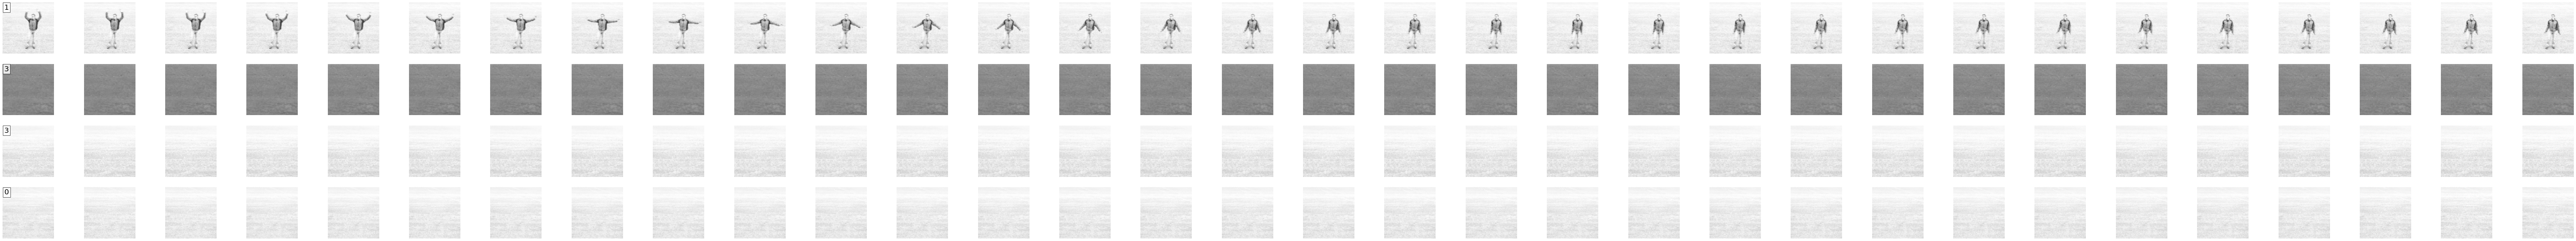

In [ ]:
data.show_batch(rows=4, train_or_test='test')

## Finetune a Pretrained Model

By default, the VideoLearner's R(2+1)D model is pretrained on __ig65m__ which is based on 65 million instagram videos. The dataset is described in this paper: https://arxiv.org/pdf/1905.00561.pdf

When we initialize the VideoLearner, we simply pass in the dataset. By default, the object will set the model to torchvision's ig65m R(2+1)D pre-trained model. Alternatively, we can also select the R(2+1)D model pretrained on the __kinetics__ dataset. However, it has proven to show lower accuracy overall.

In [ ]:
learner = VideoLearner(data, num_classes=5, base_model='ig65m')

Loading r2plus1d_34_32_ig65m model


Using cache found in /root/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


Check the model's Fully Connected layer.

In [ ]:
learner.model.fc

Linear(in_features=512, out_features=5, bias=True)

In the next block, our fine-tuned model could be pre-loaded, so that evaluation could be done without training. By default, the block is commented-out.

In [ ]:
# learner.load(model_name='88-trained-no-run-lr=OCP-epochs=35-bsize=5',model_dir='/content/gdrive/MyDrive/Final-project/trained-models/')

There is a function call on line 37 in the following file that causes fitting function crush. The view() function has to be replaced by reshape() function for the fit() method to work. This issue arises every time the code is downloaded from github. 

In [ ]:
#% /usr/local/lib/python3.6/dist-packages/utils_cv/action_recognition/references/metrics.py

Fine-tune the model using the `learner`'s `fit` function. One cycle policy has shown to increase the final accuracy, so it is used. The model is saved after training so that it could be reused for evaluation later.

Params to learn:
	full network
Epoch 1 =========================================================
lr=[4.000000000000002e-06]
 Phase train: batch 10 of 94
 Phase train: batch 20 of 94
 Phase train: batch 30 of 94
 Phase train: batch 40 of 94
 Phase train: batch 50 of 94
 Phase train: batch 60 of 94
 Phase train: batch 70 of 94
 Phase train: batch 80 of 94
 Phase train: batch 90 of 94
train took 106.52 sec | loss = 1.7012 | top1_acc = 18.9333  | top5_acc = 100.0000
 Phase valid: batch 10 of 31
 Phase valid: batch 20 of 31
 Phase valid: batch 30 of 31
valid took 16.18 sec | loss = 1.7098 | top1_acc = 11.2903  | top5_acc = 100.0000
Epoch 2 =========================================================
lr=[1.9490484561964424e-05]
 Phase train: batch 10 of 94
 Phase train: batch 20 of 94
 Phase train: batch 30 of 94
 Phase train: batch 40 of 94
 Phase train: batch 50 of 94
 Phase train: batch 60 of 94
 Phase train: batch 70 of 94
 Phase train: batch 80 of 94
 Phase train: batch 90 of 94
train took

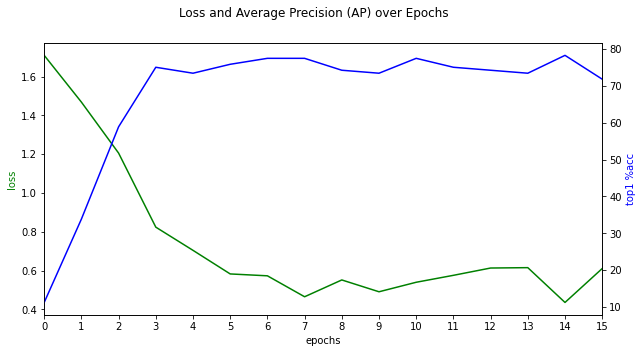

In [ ]:
model_path_name_pt = f'/content/gdrive/MyDrive/Final-project/trained-models3/trained-hmdb51-lr={LR}-epochs={EPOCHS}-bsize={BATCH_SIZE}.pt'

learner.fit(lr=LR, epochs=EPOCHS, model_dir='/content/gdrive/MyDrive/Final-project/training-models/', use_one_cycle_policy=True)
learner.save(model_path_name_pt)

## Evaluate on our dataset with children

In [ ]:
# Path to dataset excluding 'run' and 'go' action (so that labels match)
DATA_PATH = '/content/gdrive/MyDrive/Final-project/dataset-cut-exclude-run-go'
data = VideoDataset(DATA_PATH, batch_size=BATCH_SIZE, num_samples=1, sample_length=MODEL_INPUT_SIZE, video_ext="webm")
learner2 = VideoLearner(data, num_classes=5, base_model='ig65m')
learner2.load(model_name='trained-icpr-lr=OCP-epochs=16-bsize=4',model_dir='/content/gdrive/MyDrive/Final-project/trained-models/')
ret = learner2.evaluate()

Loading r2plus1d_34_32_ig65m model


Using cache found in /root/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


102 samples of torch.Size([3, 32, 112, 112])
Processsing 100 of 102 samples..
Avg. inference time per video (102 clips) = 606.77 ms
Video prediction accuracy = 0.33
Clip prediction accuracy = 0.26


## Predict using 3rd party video

Now that we've trained a model, we run a prediction on two of videos that we recorded with Andrey's younger brother and see how it works. He hasn't seen the videos from the dataset, we just asked him to perform the actions we name.

Total frames = 1816


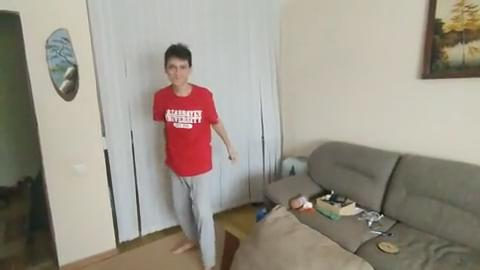

In [16]:
# the first video checks waving, clapping and boxing
test_vid = str("/content/gdrive/MyDrive/Final-project/predict-vids/1-480.mp4")
learner2.predict_video(test_vid)

Total frames = 515


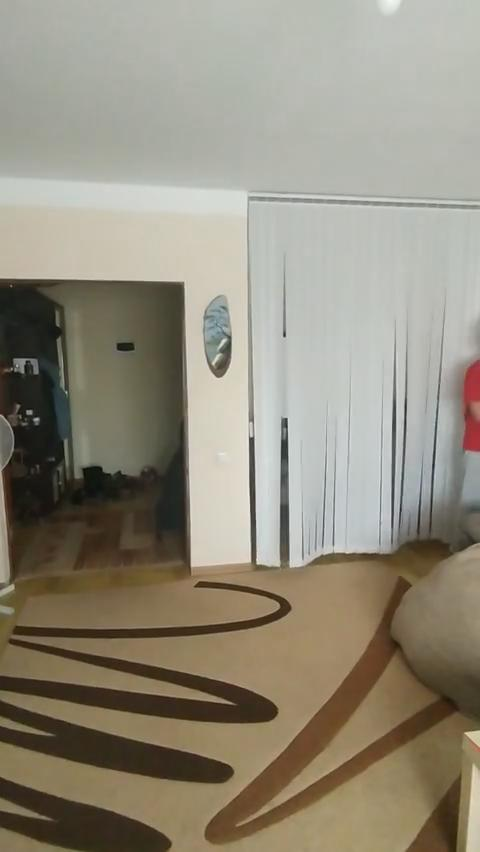

In [18]:
# the second video checks walking and jogging
test_vid = str("/content/gdrive/MyDrive/Final-project/predict-vids/2-480.mp4")
learner2.predict_video(test_vid)

## Conclusion
The evaluation has shown expected lower results. This proves that action recognition model, that is trained on adults performs worse on children. In prediction of even less similar video, the adults-trained model has failed completely. This proves the necessity of training action-recognition models on children too.